# ARID1A Final Notebook

TODO: On volcano plot, take 1/2 of bonferroni p-val cutoff, see which proteins meet that cutoff, list how many of these are upregulated and how many are downregulated.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. Available datasets may be
viewed using CPTAC.list(). In order to access a specific data set,
import a CPTAC subfolder using either 'import CPTAC.Dataset' or 'from
CPTAC import Dataset'.
******
Version: 0.2.5
******
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


#### GET CPTAC DATA

In [2]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()
transcriptomics = CPTAC.get_transcriptomics()
transcriptomics_columns = CPTAC.get_transcriptomics_cols()

# Look at transcript levels of ARID1A Interacting Proteins

### 1. Create a list of interacting proteins (via uniprot and string)

In [3]:
'''List of some of known ARID1A interacting proteins'''
siteList = ['CTCF','RUNX1','EZH2','TP53','ARID1B','BAF250B','SMARCA4','BRG1','BAF190A','SMARCA2','BRM','BAF190B','SMARCE1','ACTL6A','BAF53','SMARCC1','BAF155','SMARCC2','BAF170','SMARCB1','SNF5','BAF47','PHF10','SMARCA1','SMARCD1','SMARCD2','PTEN']

### 2a. Look through our list of proteins, test for difference in transcriptomics levels when ARID1A is mutated

In [22]:
'''Keep track of p-values for each interacting protein'''
p_values = []
site_names = []
gene = 'ARID1A'

'''Perform a T-Test comparing transcriptomics levels when ARID1A is mutated vs wildtype, in tumor patients only'''
for site in siteList:
    if site in transcriptomics_columns:
        transdf = CPTAC.compare_mutations(transcriptomics, site, gene)
        '''Look only at Tumor patients'''
        transdf = transdf.loc[transdf[gene+ "_Sample_Status"] == "Tumor"]
        '''Split wildtype and mutated groups'''
        wtdf = transdf.loc[transdf[gene + "_Mutation"] == "Wildtype_Tumor"]
        mutateddf = transdf.loc[transdf[gene + "_Mutation"] != "Wildtype_Tumor"]
        '''Do a t-test to compare the mutated and wildtype'''
        ttest = scipy.stats.ttest_ind(wtdf[site + "_omics"], mutateddf[site + "_omics"])
        p_values.append(ttest[1])
        site_names.append(site)
        
'''Adjust for multiple testing using a bonferroni correction'''
bonferroniCutoff = .05/ len(site_names)
print("Bonferroni Adjusted P Value: ", bonferroniCutoff)

significantSites = []
significantPvals = []

unsignificantSites = []
unsignificantPvals = []

for i in range(0, len(p_values)):
    if p_values[i] <= bonferroniCutoff:
        significantPvals.append(p_values[i])
        significantSites.append(site_names[i])
    else:
        unsignificantPvals.append(p_values[i])
        unsignificantSites.append(site_names[i])

Bonferroni Adjusted P Value:  0.0029411764705882353


### 2b. Print list of interacting proteins with their p-values, significant and insignificant

In [23]:
bfSignificantVals = dict(zip(significantSites, significantPvals))
bfUnsignificantVals = dict(zip(unsignificantSites, unsignificantPvals))
print("Significant Proteins:")
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in bfSignificantVals.items()) + "\n}")

print("\nUnsignificant Proteins:")
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in bfUnsignificantVals.items()) + "\n}")

Significant Proteins:
{
TP53: 0.0005722782622880464
}

Unsignificant Proteins:
{
CTCF: 0.027097656461057048
RUNX1: 0.28917336902017066
EZH2: 0.024043246022528535
ARID1B: 0.1380664204429325
SMARCA4: 0.15375805697493475
SMARCA2: 0.48533815358894716
SMARCE1: 0.05451641386469496
ACTL6A: 0.8562335281707476
SMARCC1: 0.03818000998497696
SMARCC2: 0.026144713069129223
SMARCB1: 0.08032724495382437
PHF10: 0.058071979893612666
SMARCA1: 0.005066469654111812
SMARCD1: 0.690941006229377
SMARCD2: 0.102644565523063
PTEN: 0.17020455245614546
}


### 3. Plot significant proteins, mutated vs wildtype

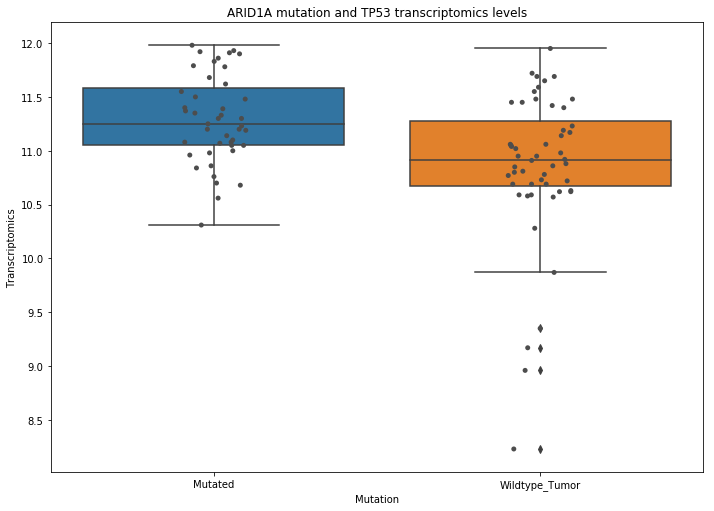

In [25]:
'''TP53 is only interacting protein showing significantly different transcript levels when ARID1A is mutated'''
gene = "ARID1A"
site = "TP53"

'''Compare TP53 Transcriptomics when ARID1A is mutated'''
genedf = CPTAC.compare_mutations(transcriptomics, site, gene)
genedf = genedf.loc[genedf[gene+"_Sample_Status"] == "Tumor"].drop(gene+"_Sample_Status", axis = 1)

'''Classify all mutations as "mutated" for the plot'''
for i, row in genedf.iterrows():
    id = i
    if row[gene + '_Mutation'] != 'Wildtype_Tumor':
        #genedf.set_value(id,'Mutation','Mutated')
        genedf.at[id,gene+'_Mutation'] = 'Mutated'

'''Generate the plot'''
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
phos_boxplot = sns.boxplot(data=genedf, x=gene+"_Mutation",y=site+"_omics")
phos_boxplot.set_title(gene + " mutation and " + site + " transcriptomics levels")
phos_boxplot = sns.stripplot(data=genedf, x=gene+"_Mutation", y=site+"_omics",jitter=True, color=".3")
phos_boxplot.set(xlabel="Mutation",ylabel="Transcriptomics")
plt.show()







TP53 seems to be the only interacting protein with significantly different transcript levels when ARID1A is mutated. TP53 transcription may be affected by ARID1A Mutation. None of the other interacting proteins' transcript levels seem to be affected by ARID1A Mutation






# Look at ARID1A Mutation effect on all proteins transcript levels

### 1. Look through all proteins, use a ttest to compare transcript levels when ARID1A is mutated

In [26]:
'''Looking at all proteins transcription levels'''
siteList = transcriptomics_columns

'''Track the p-value comparing mutated and wildtype transcriptomics for all proteins when ARID1A is mutated'''
p_values = []
site_names = []
gene = 'ARID1A'

'''Perform a T-Test comparing transcriptomics levels when ARID1A is mutated vs wildtype, in tumor patients only'''
for site in siteList:
    transdf = CPTAC.compare_mutations(transcriptomics, site, gene)
    transdf = transdf.loc[transdf[gene+"_Sample_Status"] == "Tumor"]
    '''Split into mutated and wildtype groups'''
    wtdf = transdf.loc[transdf[gene+"_Mutation"] == "Wildtype_Tumor"]
    mutateddf = transdf.loc[transdf[gene+"_Mutation"] != "Wildtype_Tumor"]
    '''use a ttest to compare the mutated and wildtype groups'''
    ttest = scipy.stats.ttest_ind(wtdf[site+"_omics"], mutateddf[site+"_omics"])
    p_values.append(ttest[1])
    site_names.append(site)

'''Adjust for multiple testing using a bonferroni correction'''
bonferroniCutoff = .05/ len(siteList)
print("Bonferroni Adjusted P Value: ", bonferroniCutoff)

significantSites = []
significantPvals = []

'''Add only the proteins that meet teh Bonferroni corrected p-value to our significant sites'''
for i in range(0, len(p_values)):
    if p_values[i] <= bonferroniCutoff:
        significantPvals.append(p_values[i])
        significantSites.append(site_names[i])

Bonferroni Adjusted P Value:  1.7820864668353709e-06


### 2. Print all statistically significant proteins, their corresponding p-value

In [27]:
'''Make a dict of sites-p_values'''
bfSignificantVals = dict(zip(significantSites, significantPvals))

'''Print off significant sites with their corresponding p-value'''
for key, value in bfSignificantVals.items():
    print(key, "  :  ", value)

CDH1   :   1.324795467653071e-07
EYA4   :   1.6834413726712495e-07
FAM110B   :   1.5679023211730672e-06
FAM57A   :   3.7371129241595914e-07
LHCGR   :   1.3680577904455822e-06
LRBA   :   8.352877744007977e-07
PCLAF   :   3.8604336128361855e-07
PRNP   :   7.546881016167983e-09
SAPCD2   :   7.544245063885869e-08
TDRD10   :   9.668602521604662e-07
WDR34   :   1.3086085097530848e-06


We have 11 proteins that have significantly different transcript levels when ARID1A is mutated, after adjusting for multiple testing using a bonferroni correction.

### 3. Show most significant protein (selected by lowest p-value)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


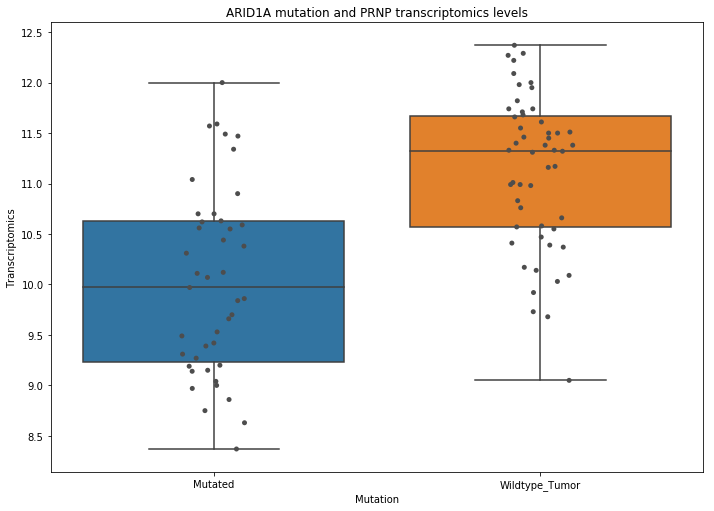

In [29]:
'''Use ARID1A as gene'''
gene = "ARID1A"

'''PRNP selected for having lowest p-value'''
site = "PRNP"

'''Compare PRNP Transcripts when ARID1A is mutated'''
genedf = CPTAC.compare_mutations(transcriptomics, site, gene)
genedf = genedf.loc[genedf[gene+"_Sample_Status"] == "Tumor"].drop(gene+"_Sample_Status", axis = 1)

'''Classify all mutations as "mutated" for our plot'''
for i, row in genedf.iterrows():
    id = i
    if row[gene+'_Mutation'] != 'Wildtype_Tumor':
        genedf.set_value(id,gene+'_Mutation','Mutated')
        
'''Plot the Data'''        
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
phos_boxplot = sns.boxplot(data=genedf, x=gene+"_Mutation",y=site+"_omics")
phos_boxplot.set_title(gene + " mutation and " + site + " transcriptomics levels")
phos_boxplot = sns.stripplot(data=genedf, x=gene+"_Mutation", y=site+"_omics",jitter=True, color=".3")
phos_boxplot.set(xlabel="Mutation",ylabel="Transcriptomics")
plt.show()

## Generate volcano plot to illustrate mean difference in transcript levels

### 1. Look through our list of sites, test for difference in transcriptomics levels when ARID1A is mutated

In [3]:
p_values = []
site_names = []
gene = 'ARID1A'
siteList = transcriptomics_columns

'''Perform a T-Test comparing transcriptomics levels when ARID1A is mutated vs wildtype, in tumor patients only'''
for site in siteList:
    transdf = CPTAC.compare_mutations(transcriptomics, site, gene)
    transdf = transdf.loc[transdf[gene+"_Sample_Status"] == "Tumor"]
    '''Split into mutated and wildtype groups'''
    wtdf = transdf.loc[transdf[gene+"_Mutation"] == "Wildtype_Tumor"]
    mutateddf = transdf.loc[transdf[gene+"_Mutation"] != "Wildtype_Tumor"]
    '''do a ttest to compare transcriptomics the mutated and wildtype groups'''
    ttest = scipy.stats.ttest_ind(wtdf[site+"_omics"], mutateddf[site+"_omics"])
    '''Store the p-value for each protein'''
    if not np.isnan(ttest[1]):
        p_values.append(ttest[1])
        site_names.append(site)

### 2. Get the top N most significant proteins (by p-value)

In [4]:
'''Use N = 1500 here to show the 1500 most significant proteins'''
N = 1500

'''Sort our dictionary for smallest p-value, and take the top N entries'''
orig_sorted_dict = {}
pvalDict = dict(zip(site_names,p_values))
orig_sorted_dict = dict(sorted(pvalDict.items(), key=lambda kv: kv[1])[:N])

'''print the dictionary, showing the most significant p-values at the top'''
orig_sorted_dict = orig_sorted_dict
print(orig_sorted_dict)

{'PRNP': 7.546881016167983e-09, 'SAPCD2': 7.544245063885869e-08, 'CDH1': 1.324795467653071e-07, 'EYA4': 1.6834413726712495e-07, 'FAM57A': 3.7371129241595914e-07, 'PCLAF': 3.8604336128361855e-07, 'LRBA': 8.352877744007977e-07, 'TDRD10': 9.668602521604662e-07, 'WDR34': 1.3086085097530848e-06, 'LHCGR': 1.3680577904455822e-06, 'FAM110B': 1.5679023211730672e-06, 'C2CD6': 2.0336577808608763e-06, 'CTSF': 2.527450230205417e-06, 'TRPC1': 3.021739448681462e-06, 'LOC100507351': 3.395050063548379e-06, 'MAB21L2': 4.068217869649306e-06, 'GNG7': 4.492990610628388e-06, 'TUBG1': 4.605114400324624e-06, 'WEE1': 4.653211624424361e-06, 'CEP78': 4.7495290215178e-06, 'LRRC8E': 4.874580134460926e-06, 'SNHG26': 5.019309135072495e-06, 'TARID': 5.571392609848492e-06, 'MSANTD3': 5.940091736459454e-06, 'ZSCAN12': 6.110885887394717e-06, 'DIRC3': 6.293020728937644e-06, 'HSPB6': 6.598399094600099e-06, 'CPQ': 6.6048716041246155e-06, 'SCN2A': 6.936151562504868e-06, 'TUB': 7.230205751047019e-06, 'ZDHHC15': 7.40127750711

### 3. Find the mean difference for each of these N most significant proteins (take mean of mutated, subtract mean of wildtype)

In [5]:
gene = "ARID1A"
diffMeans = []

'''look through each protein in our top N most significant'''
for val in orig_sorted_dict:
    '''Compare transcriptomics'''
    df = CPTAC.compare_mutations(transcriptomics, val, gene)
    df = df.loc[df[gene+"_Sample_Status"] == "Tumor"].drop(gene+"_Sample_Status", axis = 1)
    '''divide into mutated and wildtype groups'''
    mutatedf = df.loc[df[gene+"_Mutation"]!="Wildtype_Tumor"]
    wtdf= df.loc[df[gene+"_Mutation"] =="Wildtype_Tumor"]
    '''Take the mean values of the mean and wildtype groups'''
    meanMutated = np.mean(mutatedf[val+"_omics"])
    meanWt = np.mean(wtdf[val+"_omics"])
    '''store the mean values'''
    diffMean = meanMutated - meanWt
    diffMeans.append(diffMean)
    
'''Convert our p-values to the negative log of our p-values, for the volcano plot'''
pvals = []
for item in orig_sorted_dict:
    pvals.append(-1 * np.log10(orig_sorted_dict[item]))

'''Create a dictionary containing the mean difference and the negative log of our p-values'''
pvalsAndMeanDiffDict = dict(zip(diffMeans, pvals))
print(pvalsAndMeanDiffDict)

{-1.0987969588551039: 8.122232497024505, 1.036337209302328: 7.122384212613687, 0.5807200357781728: 6.877851166350732, -2.486641323792487: 6.773802003700436, 0.6615787119856833: 6.427463778896838, 0.7630635062611777: 6.413363911627308, 0.4063014311270141: 6.078163875051855, -1.1701699463327366: 6.014636293343554, 0.5481842576028608: 5.883190259853955, -1.6244856887298744: 5.863895556459828, -1.3045617173524127: 5.80468099694298, -1.3435644007155618: 5.691722127316942, -1.0639579606440037: 5.597317387649905, -1.1494007155635089: 5.519742985688001, -1.8515831842576: 5.469153817211904, 0.4113193202146679: 5.390595796886759, -1.0275044722719144: 5.347464488986886, 0.41593470483005746: 5.3367595765827485, 0.6185912343470488: 5.332247195644302, 0.42940071556350823: 5.323349454269274, 0.509584078711983: 5.312062785737664, -1.0203980322003545: 5.299356055658506, -1.89663237924866: 5.254036236212459, 0.31788014311270274: 5.2262068478924615, -0.4605679785330956: 5.213895826071943, -1.131672629695

### 4. Format the data in a dataframe in order to generate the plot

In [6]:
'''Make a dataframe to plot our data'''
df = pd.DataFrame({'-Log10(p-value)': pvals, 'Mean Difference':diffMeans})

'''This cutoff line is the bonferroni corrected p-value used to determine significance'''
bonferroniCutoff= 1.7820864668353709e-06
cutoffLine = (-1* np.log10(bonferroniCutoff))

### 5. Plot the mean difference against the -log10(p-value) for each of our top 1500 most significant proteins

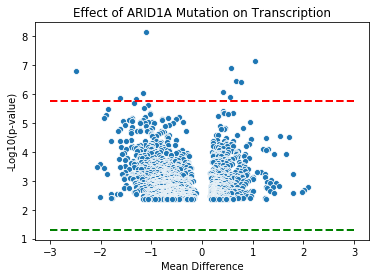

In [7]:
ax = sns.scatterplot(x = "Mean Difference", y = "-Log10(p-value)", data =df)
ax.set_title("Effect of ARID1A Mutation on Transcription")

'''Generate lines illustrating our bonferroni corrected p-value and the unadjusted p-value (.05) cutoffs on our plot.'''
ax.plot([-3,3],[cutoffLine,cutoffLine], linewidth=2, linestyle = '--', color="red")
unadjustedPval = (-1 * np.log10(.05))
ax.plot([-3,3],[unadjustedPval,unadjustedPval],linewidth=2, linestyle = '--', color="green")

### 6. Determine, of top 100 most significant proteins (based on p-value) how many are upregulated, and how many are downregulated.

In [21]:
'''Store the values that are upregulated and downregulated'''
upregulated = []
downregulated = []
num = 0
number_of_top_to_see = 100

'''loop through dictionary, of top N p-values, add to upregulated or downregulated list'''
for key, val in pvalsAndMeanDiffDict.items():
    num += 1
    if num <= number_of_top_to_see:
        if key < 0: 
            downregulated.append(key)
        if key > 0:
            upregulated.append(key)

'''Print number of upreguated and downregulated proteins'''          
print("Upregulated: ", len(upregulated))
print("Downregulated: ", len(downregulated))

Upregulated:  29
Downregulated:  71


This seems to illustrate that ARID1A Mutation has significant effects on transcription levels of other proteins. There are 11 proteins whose transcription levels are significantly different (after adjusting for multiple testing using the bonferroni correction) when ARID1A is mutated. Generally, the proteins whose transcript levels are most affected by ARID1A mutation are downregulated when ARID1A is mutated.

# Examine ARID1A and Interacting proteins abundance when ARID1A is mutated

### 1. Compare protein abundance for ARID1A interacting proteins with ARID1A mutation

In [92]:
'''Use the same interacting protein list, generated from uniprot and string'''
protList = ['ARID1A','RUNX1','DPF2','EZH2','TP53','ARID1B','BAF250B','SMARCA4','BRG1','BAF190A','SMARCA2','BRM','BAF190B','SMARCE1','ACTL6A','BAF53','SMARCC1','BAF155','SMARCC2','BAF170','SMARCB1','SNF5','BAF47','PHF10','SMARCA1','SMARCD1','SMARCD2']

'''Account for multiple testing by adjusting our p-value cutoff using a bonferroni correction'''
pcutoff = 0.05/ len(protList)
gene = 'ARID1A'

'''Look through each of the interacting proteins, use a ttest to compare mutated and wildtype groups'''
sigResults = {};
unSigResults = {};
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross.loc[cross[gene+"_Sample_Status"] == 'Tumor'].drop(gene+"_Sample_Status", axis = 1)
        cross = cross[[gene+"_Mutation", protein+"_omics"]].dropna(axis=0)
        '''split into mutated and wildtype groups'''
        mutated = cross.loc[cross[gene+"_Mutation"] != "Wildtype_Tumor"]
        wt = cross.loc[cross[gene+"_Mutation"] == "Wildtype_Tumor"]
        '''use a t-test to see if there is significant difference in protein abundance bewteen the 2 groups'''
        stat, pval = scipy.stats.ttest_ind(mutated[protein+"_omics"], wt[protein+"_omics"])
        '''track significant and unsignificant results'''
        if(pval <= pcutoff):
            sigResults[protein]= pval
        else:
            unSigResults[protein] = pval
            
'''Print the results'''            
print("Bonferroni Corrected P-Value Cutoff: ", pcutoff)
print("\nSignificant Results: ")
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in sigResults.items()) + "\n}")

print("\nUnsignificant Results: ")
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in unSigResults.items()) + "\n}")

Bonferroni Corrected P-Value Cutoff:  0.001851851851851852

Significant Results: 
{
ARID1A: 1.0250180625304501e-10
DPF2: 2.1666091867648467e-07
SMARCE1: 0.00014980267328352896
SMARCC2: 8.27047328548376e-05
SMARCB1: 6.885135488619889e-05
SMARCD1: 0.00017449149012151386
SMARCD2: 0.0017325528008018882
}

Unsignificant Results: 
{
RUNX1: 0.9867856279080296
EZH2: 0.023465522844906734
TP53: 0.6216919230673713
ARID1B: 0.2933959777880062
SMARCA4: 0.011534265835122267
SMARCA2: 0.015908722488902433
ACTL6A: 0.0027479350847987695
SMARCC1: 0.17867308411819643
PHF10: 0.24142597337540306
SMARCA1: 0.06615103504129119
}


### 2. Generate a dataframe of protein abundance among our significant proteins

In [93]:
'''Start with ARID1A mutation dataframe'''
plotdf = CPTAC.compare_mutations(proteomics, gene)
plotdf = plotdf.loc[plotdf["Sample_Status"] == 'Tumor'][['Mutation', gene]]

'''Add in each significant protein to the dataframe'''
for protein in sigResults:
    if(protein != 'ARID1A'):
        proteindf = CPTAC.compare_mutations(proteomics, protein, gene)[[protein+"_omics"]]
        #print(proteindf)
        plotdf = plotdf.join(proteindf)

'''Rename the Columns for the plot'''
plotdf = plotdf.rename(index=str, columns={"DPF2_omics":"DPF2",
                                           "SMARCE1_omics":"SMARCE1",
                                           "SMARCC2_omics":"SMARCC2",
                                           "SMARCB1_omics":"SMARCB1",
                                           "SMARCD1_omics":"SMARCD1",
                                           "SMARCD2_omics":"SMARCD2"})

'''Classify all mutations as "Mutation", wildtype_tumor as wildtype tumor for the plot'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutation',
                                      'Frame_Shift_Ins': 'Mutation',
                                      'Nonsense_Mutation': 'Mutation',
                                      'Wildtype_Tumor': 'Wildtype Tumor',
                                      'Missense_Mutation': 'Mutation'
                                     }})

plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Protein', value_name='Signal')
plotdf = plotdf.dropna(axis=0)

### 3. Generate the plot showing the significant interacting proteins and their protein abundance

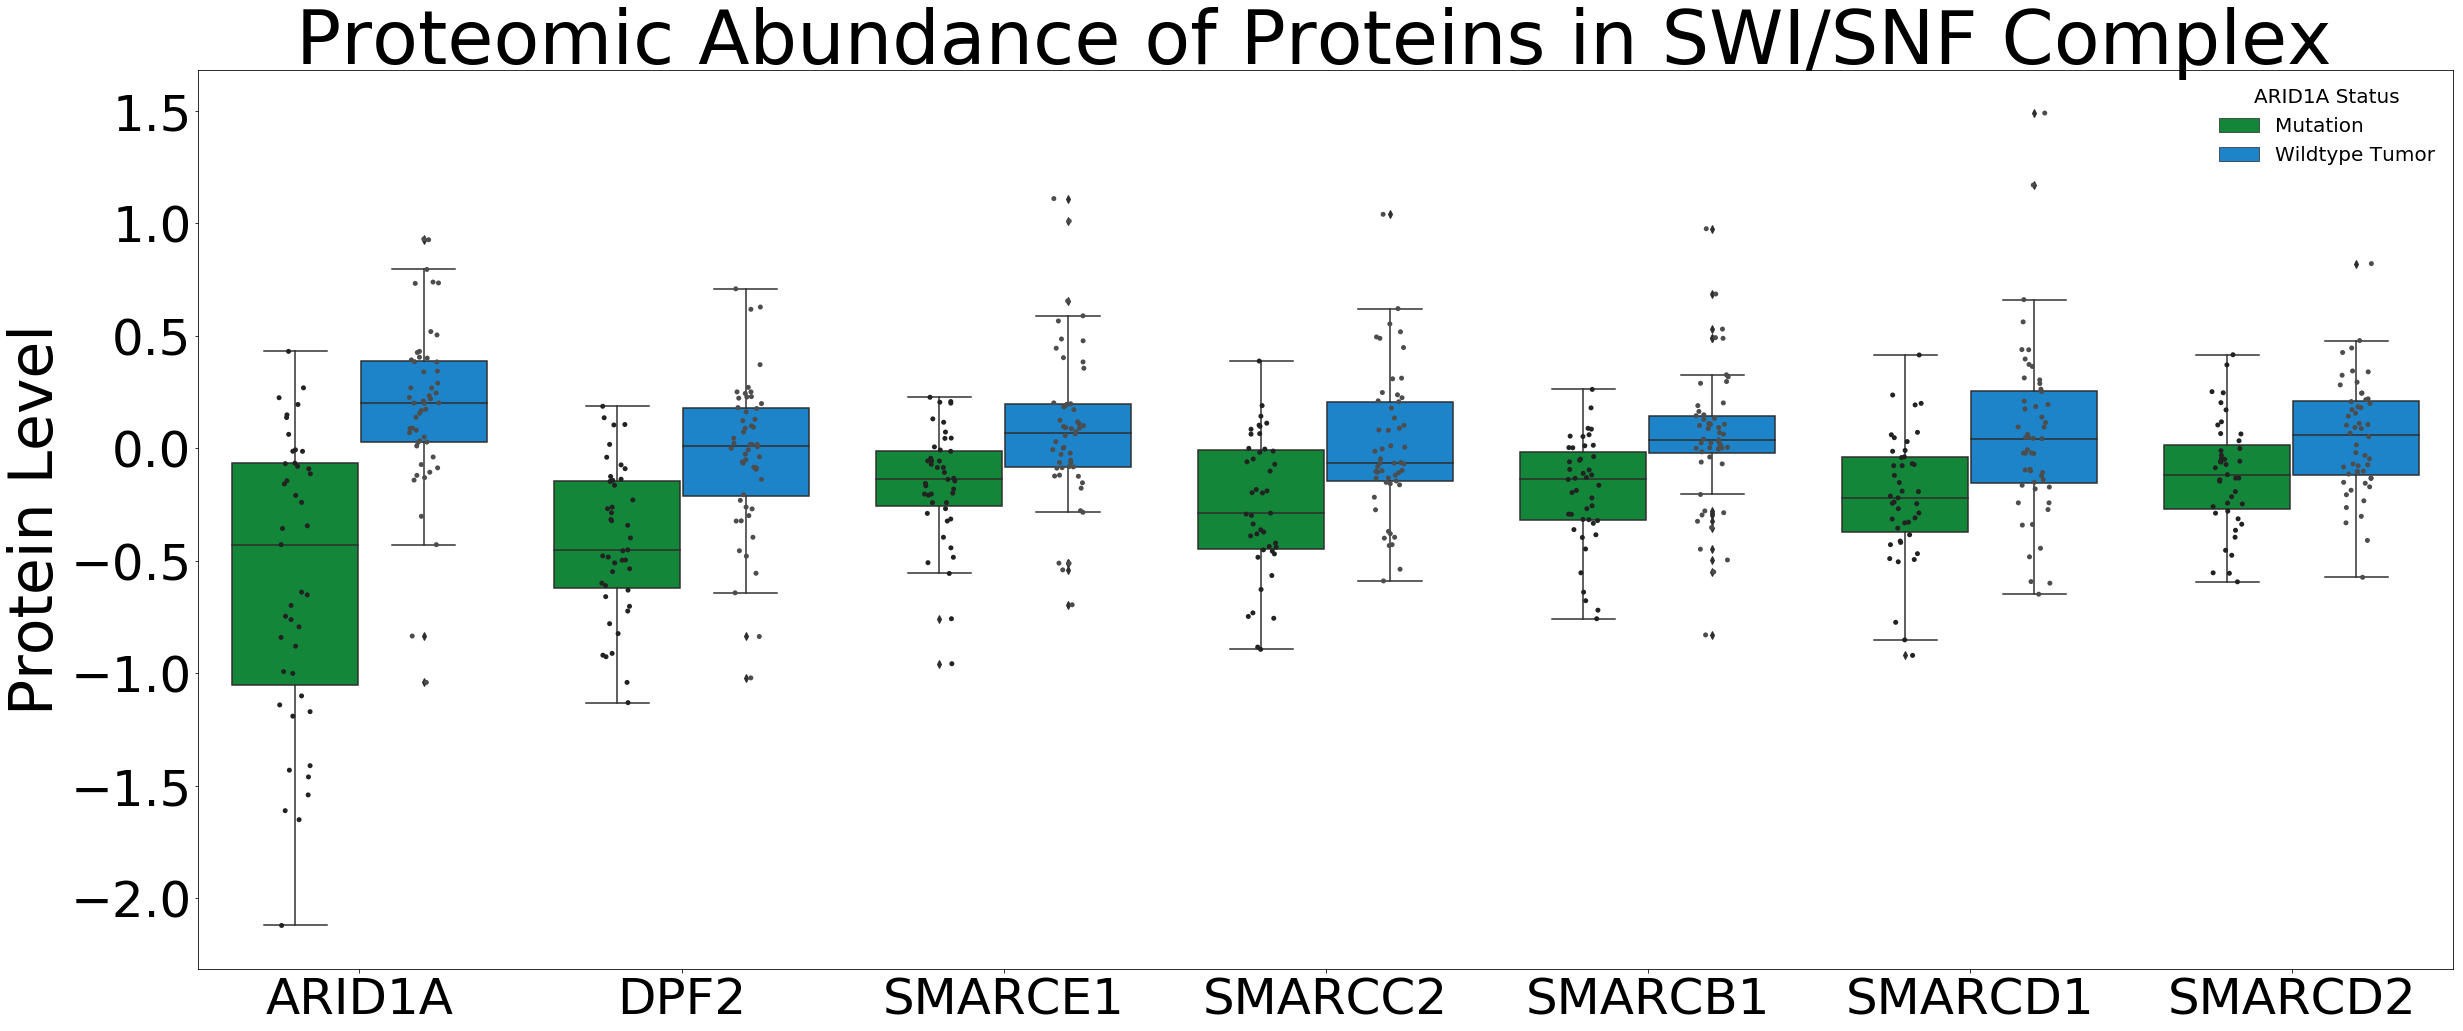

In [94]:
'''Formatting options'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutation": "#009933", "Wildtype Tumor": "#008ae6"}

'''Create the plot'''
boxplt = sns.boxplot(x='Protein', y='Signal', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Signal', hue='Mutation', dodge=True, jitter=True, color='.3')

'''Add styling'''
boxplt.set_xlabel('')
boxplt.set_ylabel('Protein Level', fontsize='60')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Proteomic Abundance of Proteins in SWI/SNF Complex ', fontsize = '75')

'''Adjust legend'''
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutation', 'Wildtype Tumor'], title='ARID1A Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')

'''Show figure'''
fig = boxplt.get_figure()
plt.show()

We see that when ARID1A is mutated, protein abundance of other proteins in the SWI/SNF complex are also significantly lower.